In [1]:
import ipaddress
import os
import yaml
from typing import Dict, List, Tuple
from zipfile import ZipFile

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
from rasterio import plot
from shapely import Point

from aimlsse_api.client import SatelliteDataClient
from aimlsse_api.data import Credentials, QueryStates

In [2]:
data_dir = 'data'
product_id = '405c25dc-37a3-45bd-b07c-1dce4c56b138'

Make sure that the file `login.yml` exists. If not, create a new one and store your credentials for the [Copernicus OpenAPI Hub](https://scihub.copernicus.eu/dhus/#/home) in the following form:
```
username: <copernicus-username>
password: <copernicus-password>
```
The file is excluded from git to make sure that credentials are kept private.

In [3]:
login_config = yaml.safe_load(open('login.yml'))
username = login_config['username']
password = login_config['password']
copernicus_login = Credentials(username, password)

In [4]:
satellite_client = SatelliteDataClient(ipaddress.ip_address('127.0.0.1'), 8010)
request_state = satellite_client.requestProduct(
    product_id,
    copernicus_login
)
print(request_state)
assert request_state == QueryStates.AVAILABLE, 'State needs to be "available" to continue!'

QueryStates.AVAILABLE


In [12]:
locations = gpd.GeoDataFrame(
    pd.DataFrame([
        ('ETOR', Point(8.46339, 49.56357)),
        ('EDFE', Point(8.64150, 49.96083)),
        ('EDDF', Point(8.59861, 50.04639)),
        ('ETOU', Point(8.32540, 50.04982))
    ], columns=['name', 'geometry']),
    crs='EPSG:4326'
)

In [13]:
zip_filepath = satellite_client.extractFeatures(product_id, 3000,
    ['B1', 'B2', 'B3', 'B8A', 'B11'],
    locations,
    data_dir
)

In [14]:
product_path = os.path.join(data_dir, product_id)
if not os.path.exists(product_path):
    product_zip_path = product_path +'.zip'
    if not os.path.exists(product_zip_path):
        raise FileExistsError(f'Could not find directory {product_path} or zip-file {product_zip_path}')
    with ZipFile(product_zip_path) as zip_file:
        zip_file.extractall(data_dir)

In [15]:
bands = os.listdir(product_path)
print(bands)

['B1', 'B11', 'B2', 'B3', 'B8A']


In [16]:
image_drivers = {
    'jp2': 'JP2OpenJPEG'
}

In [17]:
bands_with_images: Dict[str, List[Tuple[rasterio.DatasetReader, str]]] = {}
for band in bands:
    band_path = os.path.join(product_path, band)
    station_files = os.listdir(band_path)
    print(f'Band {band} has station-files: {station_files}')
    images_station_names_tuples = []
    for station_file in station_files:
        station_image_path = os.path.join(band_path, station_file)
        station_image = rasterio.open(station_image_path, driver=image_drivers[Path(station_image_path).suffix[1:]])
        images_station_names_tuples += [(station_image, Path(station_image_path).stem)]
    bands_with_images[band] = images_station_names_tuples

Band B1 has station-files: ['EDDF.jp2', 'EDFE.jp2', 'ETOU.jp2']
Band B11 has station-files: ['EDDF.jp2', 'EDFE.jp2', 'ETOU.jp2']
Band B2 has station-files: ['EDDF.jp2', 'EDFE.jp2', 'ETOU.jp2']
Band B3 has station-files: ['EDDF.jp2', 'EDFE.jp2', 'ETOU.jp2']
Band B8A has station-files: ['EDDF.jp2', 'EDFE.jp2', 'ETOU.jp2']


In [18]:
num_bands = len(bands_with_images)

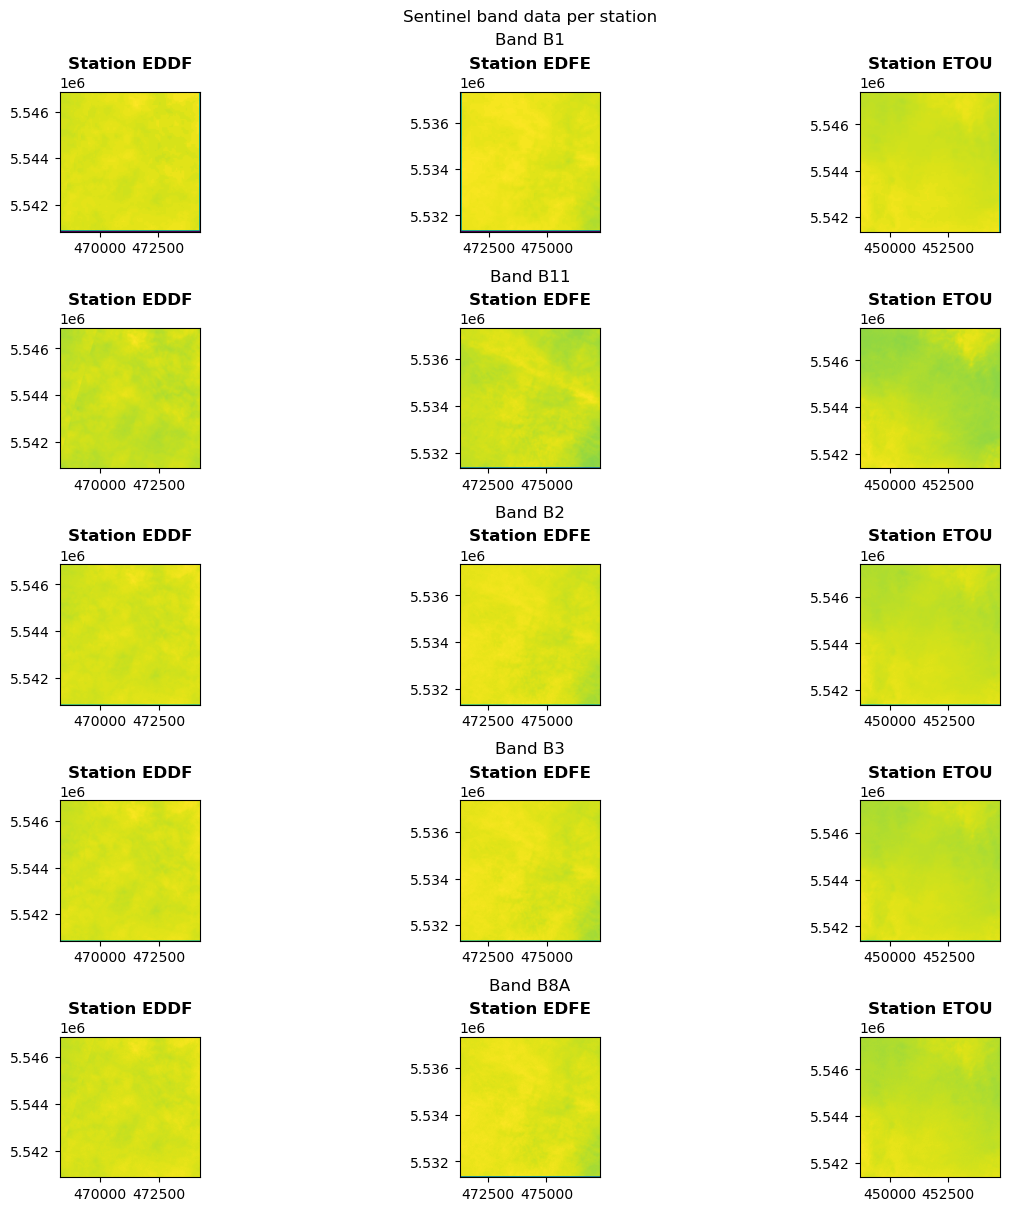

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(12, 12))
fig.suptitle('Sentinel band data per station')

subfigs: List[plt.Figure] = fig.subfigures(nrows=num_bands, ncols=1)
for v_index, (band, images) in enumerate(bands_with_images.items()):
    subfig = subfigs[v_index]
    subfig.suptitle(f'Band {band}')

    num_images = len(images)
    axs = subfig.subplots(nrows=1, ncols=num_images)
    for h_index, (image, station) in enumerate(images):
        ax = axs[h_index]
        plot.show(image, ax=ax, title=f'Station {station}', cmap='viridis')